<a href="https://colab.research.google.com/github/Viktoriya89/doc_tex_source/blob/main/Caltech101_module4_VSergeyeva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projet Deep Image du module 4, en ré-utilisant le TP vu en cours.

In [21]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [22]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn

In [23]:
# Progrès
from tqdm import tqdm
from tqdm.autonotebook import tqdm
#from tqdm import tqdm_notebook as tqdm

#matpotlib 
#import matplotlib
import matplotlib.pyplot as plt

# Modules (torch, nn, F et optim)
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
from PIL import Image

Processing /root/.cache/pip/wheels/4f/0a/2a/7e3391063af230fac4b5fdb4cc93adcb1d99af325b623cea03/Pillow-4.0.0-cp37-cp37m-linux_x86_64.whl
ERROR: torchvision 0.9.1+cu101 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.16.2 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: bokeh 2.3.0 has requirement pillow>=7.1.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.1.0
    Uninstalling Pillow-7.1.0:
      Successfully uninstalled Pillow-7.1.0


ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


Chargement des images  Caltech101, environ 10000 images 300X200 pixels. Les objets sont rangés selon 101 catégories. 
http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz

Documentation pour ImageFolder: https://pytorch.org/vision/stable/datasets.html#imagefolder

D'abord, je charge le dataset total, avec son loader et je visualise une image pour verifier que les images sont bien chargées.

Ici, image_size = 224! Donc, pour tous les modeles sauf Inception_v3.

Dimension d'un mini-batch de loader:  torch.Size([32, 3, 224, 224])
 img.size() =  torch.Size([3, 224, 224])
 img.dim() =  3
 img.size()[0] =  3


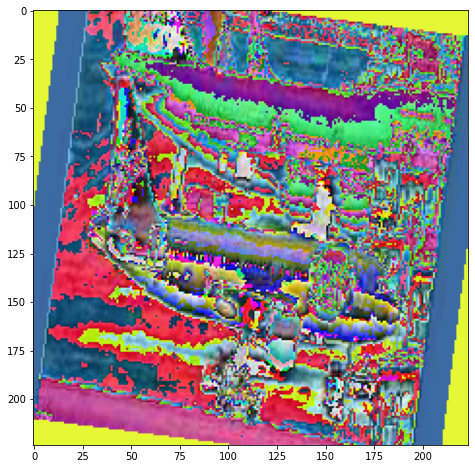

In [24]:
batchsize = 32
image_size = 224
#image_size = 299
# Inveption_v3 requires input_size = 299!!!

# Transformations à appliquer pour l'ensemble d'apprentissage
transformTrain = transforms.Compose(
    [transforms.Resize((image_size, image_size)),
     transforms.CenterCrop(image_size),
     transforms.ToTensor(),
     transforms.RandomRotation(10),
     transforms.RandomHorizontalFlip(), 
     #transforms.RandomResizedCrop(32),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
     ])

train_dataset = datasets.ImageFolder('drive/MyDrive/data/101_ObjectCategories', transform=transformTrain)
loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchsize, pin_memory=True, shuffle=True)

# Recuperation du premier batch
images,labs=iter(loader).next()

print("Dimension d'un mini-batch de loader: ", images.size())
img = images[0]
print(" img.size() = ", img.size())
print(" img.dim() = ", img.dim())
print(" img.size()[0] = ", img.size()[0])

#Visualisation des images
fig=plt.figure(figsize=(8, 8))
tr = transforms.ToPILImage()
img0 = tr(img)
plt.imshow(np.array(img0))

Maintenant, je veux créer les ensembles d'apprentissage (train) et de validation (test), avec une proportion 90%:10%. Nous avons 8683 images en total.

 length raw dataset =  8683
 split =  868
 Train length =  7815
 Test length =  868
 Train size:  7815
Dimension d'un mini-batch de train_loader:  torch.Size([32, 3, 224, 224])
 img_bx.size() =  torch.Size([3, 224, 224])
 img_bx.dim() =  3
 img_bx.size()[0] =  3


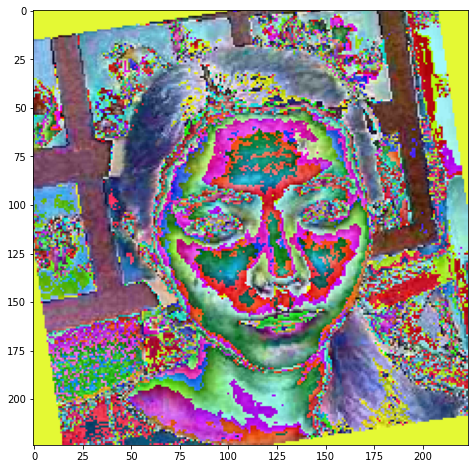

In [25]:
from torch.utils.data import Subset
from torch.utils.data.sampler import SubsetRandomSampler

proportion = 0.1

num_raw = len(train_dataset)
indices = list(range(num_raw))
split = int(np.floor(proportion * num_raw)) # 10% pour l'ensemble de validation

print(" length raw dataset = ", num_raw)
#print(" indices: ", indices)
print(" split = ", split)

# On melange les indices des images
#np.random.seed(13)
np.random.shuffle(indices)
#print(" indices: ", indices)

# division en 2 ensembles, l'indice = split est la frontiere entre train et test
train_indices =  indices[split:]
print(" Train length = ", len(train_indices))
test_indices = indices[:split]
print(" Test length = ", len(test_indices))

train_subset = Subset(train_dataset, train_indices)

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batchsize, pin_memory=True, shuffle=True)

train_size = len(train_subset)
print(" Train size: ", train_size)

# Recuperation du premier batch
bx, by = iter(trainloader).next()
print("Dimension d'un mini-batch de train_loader: ", bx.size())
img_bx = bx[0]
print(" img_bx.size() = ", img_bx.size())
print(" img_bx.dim() = ", img_bx.dim())
print(" img_bx.size()[0] = ", img_bx.size()[0])

#Visualisation des images
fig=plt.figure(figsize=(8, 8))
img1 = tr(img_bx)
plt.imshow(np.array(img1))

Je crée un bloque "transform" different pour le "test", avec uniquement la normalisation, resize et la transformation vers le tenseur.

 Test size:  868
Dimension d'un mini-batch de test_loader:  torch.Size([32, 3, 224, 224])
 img_bx.size() =  torch.Size([3, 224, 224])
 img_bx.dim() =  3
 img_bx.size()[0] =  3


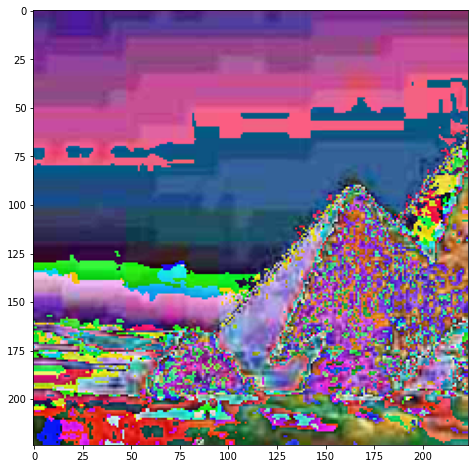

In [26]:
# Pour l'ensemble de validation   
transformTest = transforms.Compose(
    [transforms.Resize((image_size, image_size)),
     transforms.CenterCrop(image_size),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# on charge avec la transformations differentes pour le test
test_dataset = datasets.ImageFolder('drive/MyDrive/data/101_ObjectCategories', transform=transformTest)

# on refait la même procedure que avant pour créer le loader avec les indices des images
test_subset = Subset(test_dataset, test_indices)
testloader = torch.utils.data.DataLoader(test_subset, batch_size=batchsize, pin_memory=True, shuffle=True)

test_size = len(test_subset)
print(" Test size: ", test_size)

# Recuperation du premier batch
bx, by = iter(testloader).next()
print("Dimension d'un mini-batch de test_loader: ", bx.size())
img_bx = bx[0]
print(" img_bx.size() = ", img_bx.size())
print(" img_bx.dim() = ", img_bx.dim())
print(" img_bx.size()[0] = ", img_bx.size()[0])

#Visualisation des images
fig=plt.figure(figsize=(8, 8))
img1 = tr(img_bx)
plt.imshow(np.array(img1))

Les données sont maintenant separées en "train" et "test", les images sont chargées par mini-batchs de 32, avec trainloader et testloader.

Partie 2: utilisation des modèles pré-entrainés. Importation de 6 modèles. 

In [27]:
def set_parameter_requires_grad(requires_grad=True):
    for param in net.parameters():
        param.requires_grad = requires_grad

my_num_classes = 101

def train(nbEpochs=3):
    print(net)
    
    criterion = nn.CrossEntropyLoss()
    for epoch in range(nbEpochs):  
        tloss = 0.0
        i=0
        t = tqdm(iter(trainloader), total=len(trainloader), dynamic_ncols=True)
        for data in t:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            tloss += loss.item()
        
        tloss=tloss/len(trainloader)
        #tbw.add_scalar("loss/train", tloss, epoch)
        print("train loss=",epoch, tloss) 
        
        tloss=0.0
        ok = 0
        tot = 0
        with torch.no_grad():
            t = tqdm(iter(testloader), total=len(testloader))
            for data in t:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                tot += labels.size(0)
                ok += (predicted == labels).sum().item()
                tloss += loss.item()
        
        tloss=tloss/len(testloader)
        #tbw.add_scalar("loss/test", tloss, epoch)
        print("test loss=",epoch, tloss) 
               
        print('Accuracy in test', (100.0 * ok / tot))

In [28]:
from torchvision import models
net1 = models.resnet18(pretrained=True)
#print(net1)
# Derniere couche:
# (fc): Linear(in_features=512, out_features=1000, bias=True)

net2 = models.alexnet(pretrained=True)
#print(net2)
# Derniere couche:
# (6): Linear(in_features=4096, out_features=1000, bias=True)

net3 = models.squeezenet1_0(pretrained=True)
#print(net3)
# Derniere couche:
# (3): AdaptiveAvgPool2d(output_size=(1, 1))

net4 = models.vgg16(pretrained=True)
#print(net4)
# Derniere couche:
# (6): Linear(in_features=4096, out_features=1000, bias=True)

net5 = models.densenet161(pretrained=True)
#print(net5)
# Derniere couche:
# (classifier): Linear(in_features=2208, out_features=1000, bias=True)

net6 = models.inception_v3(pretrained=True)
#print(net6)
# Derniere couche x2!
# (AuxLogits): InceptionAux(
    #(conv0): BasicConv2d(
      #(conv): Conv2d(768, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      #(bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    #)
    #(conv1): BasicConv2d(
      #(conv): Conv2d(128, 768, kernel_size=(5, 5), stride=(1, 1), bias=False)
      #(bn): BatchNorm2d(768, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    #)
    #(fc): Linear(in_features=768, out_features=1000, bias=True)
# Et l'output habituel:
# (fc): Linear(in_features=2048, out_features=1000, bias=True)
# On doit modifier les 2 couches de sortie!

In [29]:
nets = [net1, net2, net3, net4, net5]
nets2 = [net6]

Je commence d'abord par resnet18.

In [30]:
# Fixons d'abord les poids du réseau :
for net in nets:
  set_parameter_requires_grad(False)

# On regarde les examples sur:
#https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

# Pour avoir 101 classes et non 1000 en sortie :
# modif net1, ResNet18
num_ftrs = net1.fc.in_features
net1.fc = nn.Linear(num_ftrs, my_num_classes)
#print(net1)
# Derniere couche
# (fc): Linear(in_features=512, out_features=101, bias=True)

# modif net2, alexnet
#(12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False) -> remove this MaxPool2d or change 3 by 1 kernel size
net2.features[12] = nn.MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
num_ftrs = net2.classifier[6].in_features
net2.classifier[6] = nn.Linear(num_ftrs, my_num_classes)
#print(net2)
# Derniere couche
# (classifier): (6): Linear(in_features=4096, out_features=101, bias=True)
# (features): (12): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)

# modif net3, squeezenet1_0
net3.classifier[1] = nn.Conv2d(512, my_num_classes, kernel_size=(1,1), stride=(1,1))
#print(net3)
# Derniere couche
# (classifier): Sequential(
    #(0): Dropout(p=0.5, inplace=False)
    #(1): Conv2d(512, 101, kernel_size=(1, 1), stride=(1, 1))
    #(2): ReLU(inplace=True)
    #(3): AdaptiveAvgPool2d(output_size=(1, 1))

# modif net4, vgg16. Idem que AlexNet.
num_ftrs = net4.classifier[6].in_features
net4.classifier[6] = nn.Linear(num_ftrs, my_num_classes)
#print(net4)
# Derniere couche
# (6): Linear(in_features=4096, out_features=101, bias=True)

# modif net5, densenet161
# (classifier): Linear(in_features=2208, out_features=1000, bias=True)
num_ftrs = net5.classifier.in_features
net5.classifier = nn.Linear(num_ftrs, my_num_classes)
#print(net5)
# Derniere couche
# (classifier): Linear(in_features=2208, out_features=101, bias=True)

# modif net6, inception_v3
net.aux_logits=False
#net.AuxLogits.fc = nn.Linear(768, my_num_classes)
net.fc = nn.Linear(2048, my_num_classes)

#net.Mixed_7a.branch3x3_2 = nn.Conv2d(192, 320, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1), bias=False)
#net.Mixed_7a.branch7x7x3_4 = nn.Conv2d(192, 192, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1), bias=False)
#net.Mixed_7b.branch3x3dbl_2 = nn.Conv2d(448, 384, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1), bias=False)
#net.Mixed_7c.branch3x3dbl_2 = nn.Conv2d(448, 384, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1), bias=False)

#net.Conv2d_1a_3x3 = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
#net.Conv2d_2a_3x3 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#net.Conv2d_4a_3x3 = nn.Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

# Finalement, la solution est de desactiver les aux_logits pour faire marcher le reseau.
# https://stackoverflow.com/questions/53476305/attributeerror-tuple-object-has-no-attribute-log-softmax

#print(net6)
# input_size = 299 !!!
# OK! 

In [31]:
# Pour les 5 premiers modeles
for net in nets:
  net.to(device)
  params_to_update = []
  for name,param in net.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)
  optimizer = optim.SGD(params_to_update, lr=0.01, momentum=0.9)
#optimizer = optim.Adam(params_to_update, lr=0.01)
  train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  


train loss= 0 1.4973254027415295



test loss= 0 0.6539963004844529
Accuracy in test 84.44700460829493



train loss= 1 0.5080477043682216



test loss= 1 0.378881497574704
Accuracy in test 91.12903225806451



train loss= 2 0.3650169311129317



test loss= 2 0.36308135371655226
Accuracy in test 90.89861751152074
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=Fal


train loss= 0 1.3201787126307585



test loss= 0 0.6626804449728557
Accuracy in test 82.14285714285714



train loss= 1 0.5178555768667435



test loss= 1 0.5578477164464337
Accuracy in test 85.9447004608295



train loss= 2 0.3452146718696672



test loss= 2 0.5084522105753422
Accuracy in test 85.9447004608295
SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      


train loss= 0 1.4400545790487407



test loss= 0 0.7784702671425683
Accuracy in test 82.37327188940093



train loss= 1 0.6513514567394646



test loss= 1 0.7999422608741692
Accuracy in test 82.6036866359447



train loss= 2 0.48034822358464707



test loss= 2 0.7367717626163669
Accuracy in test 84.21658986175115
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True


train loss= 0 1.1133602311416548



test loss= 0 0.5516245434326785
Accuracy in test 83.98617511520737



train loss= 1 0.5377251770727488



test loss= 1 0.5060371444227972
Accuracy in test 86.86635944700461



train loss= 2 0.44911478426383467



test loss= 2 0.5470142400590703
Accuracy in test 86.05990783410138
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-0


train loss= 0 1.1739931385127866



test loss= 0 0.342341865545937
Accuracy in test 94.35483870967742



train loss= 1 0.2711044219075417



test loss= 1 0.2569144666194916
Accuracy in test 94.23963133640552



train loss= 2 0.17320008756858962



test loss= 2 0.263862069696188
Accuracy in test 93.77880184331798
